In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from ipywidgets import IntProgress
from keras_tqdm import TQDMNotebookCallback

import keras
import keras_retinanet.layers
import keras_retinanet.models
import keras_retinanet.preprocessing.pascal_voc
import keras.preprocessing.image
from keras.applications.imagenet_utils import get_file

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Generate RetinaNet model

In [2]:
image = keras.layers.Input((512, 512, 3))
gt_boxes = keras.layers.Input((None, 5))

model = keras_retinanet.models.ResNet50RetinaNet([image, gt_boxes], num_classes=21)

# compile model
model.compile(loss=None, optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001))
#print(model.summary())

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Output "focal_loss" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "focal_loss" during training.


## Initialize data generators

In [3]:
train_image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    #vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

test_image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
)

train_generator = keras_retinanet.preprocessing.pascal_voc.PascalVocIterator(
    '/srv/datasets/VOCdevkit/VOC2007+12',
    'trainval',
    train_image_data_generator
)
test_generator = keras_retinanet.preprocessing.pascal_voc.PascalVocIterator(
    '/srv/datasets/VOCdevkit/VOC2007+12',
    'test',
    test_image_data_generator
)

## Train on data

In [ ]:
batch_size = 1 # batch_size > 1 is not yet supported
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator.image_names) // batch_size,
    epochs=50,
    verbose=1,
    validation_data=test_generator,
    validation_steps=500,#len(test_generator.image_names) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint('snapshots/resnet50_voc_2007.h5', monitor='val_loss', verbose=1, save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0),
    ],
)

Epoch 1/50
5011/5011 [==============================] - 608s - loss: 0.3376 - val_loss: 1.0510
Epoch 2/50
5011/5011 [==============================] - 611s - loss: 0.2998 - val_loss: 1.0773
Epoch 3/50
5011/5011 [==============================] - 609s - loss: 0.2872 - val_loss: 0.8666
Epoch 4/50
5011/5011 [==============================] - 603s - loss: 0.2701 - val_loss: 1.2190
Epoch 5/50
5011/5011 [==============================] - 607s - loss: 0.2563 - val_loss: 0.8328
Epoch 6/50
5011/5011 [==============================] - 602s - loss: 0.2457 - val_loss: 0.9719
Epoch 7/50
5011/5011 [==============================] - 603s - loss: 0.2448 - val_loss: 0.8836
Epoch 8/50
5011/5011 [==============================] - 602s - loss: 0.2254 - val_loss: 0.9577
Epoch 9/50
5011/5011 [==============================] - 599s - loss: 0.2178 - val_loss: 1.0235
Epoch 10/50
5011/5011 [==============================] - 603s - loss: 0.2037 - val_loss: 0.9299
Epoch 11/50
5011/5011 [==========================

## Display ground truth for an example

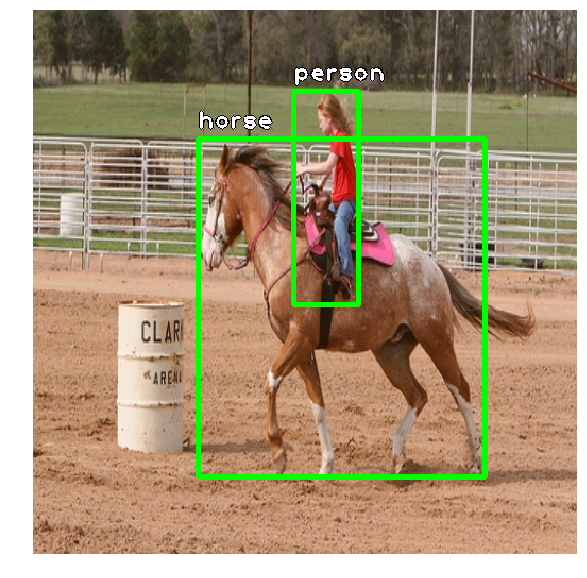

In [282]:
inputs, outputs = next(test_generator)
image, boxes = inputs
image = image[0, ...].copy()
image -= min(image.flatten())
image /= max(image.flatten())
image *= 255
image = image.astype(np.uint8)

im = image.copy()

for box in boxes[0]:
    b = box[:4].astype(int)
    label = int(box[4])
    cv2.rectangle(im, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 3)
    
    caption = keras_retinanet.preprocessing.pascal_voc.voc_labels[label]
    cv2.putText(im, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(im, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(im)
plt.show()

## Run detection on example

In [283]:
import time
start = time.time()
boxes, classification, reg_loss, cls_loss = model.predict_on_batch(inputs)
print(time.time() - start)

0.03985428810119629


## Visualize positively classified boxes

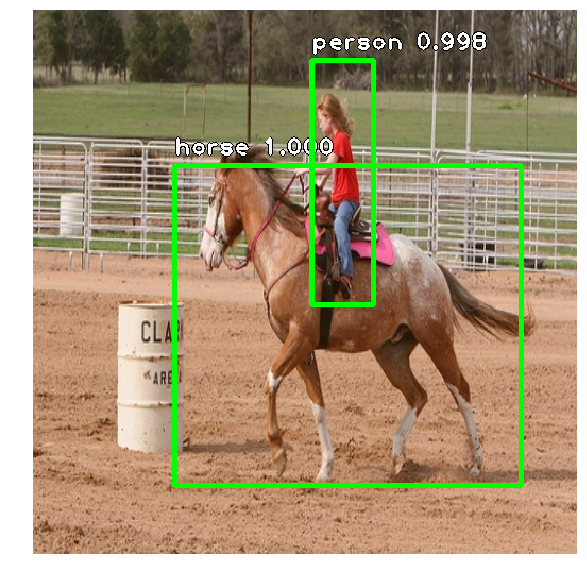

In [284]:
im = image.copy()
predicted_labels = np.argmax(classification[0, ...], axis=1)
scores = np.max(classification[0, ...], axis=1)

for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    b = boxes[0, idx, :].astype(int)
    cv2.rectangle(im, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 3)
    caption = "{} {:.3f}".format(keras_retinanet.preprocessing.pascal_voc.voc_labels[label], score)
    cv2.putText(im, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(im, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(im)
plt.show()